In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
import glob
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import shutil
import stat

img_width = 128
img_height = 128

spec_width = 256
spec_height = 256

num_imgs = 30

2.9.0


In [2]:
data_path = "C:/Users/Scrip0/Desktop/Internships/Magician AI/MagicianDatasetApp/Data"
img_ext = ["jpg","png", "jpeg"];
sound_ext = ["wav"];
ext = img_ext + sound_ext


def load_img(path):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (img_width, img_height))
    img = np.array(img) / 256.0
    return img

fr_model = keras.models.load_model('Face_recognition.h5')

def load_audio(path):
    audio = Audio.from_file(path).trim(0.05,2.05)
    
    spectrogram = Spectrogram.from_audio(audio)
    
    image = spectrogram.to_image(shape=(spec_width, spec_height),invert=False)

    return np.array(image) / 256

def prep_imgs(imgs):
    length = len(imgs)
    if (length > num_imgs):
        n = length - num_imgs
        i = (int)(length / (n + 1))
        for l in range(1, n + 1):
            imgs.pop(length - i * l)
    elif (len(imgs) < num_imgs):
        n =  num_imgs - length
        i = (int)(length / (n + 1))
        for l in range(1, n + 1):
            imgs.insert(length - i * l, imgs[length - i * l - 1])
    return imgs

In [3]:
# Delete all forlders that contain wrong number of files
# dirs = []

# for it in os.scandir(data_path + "/False"):
#     if it.is_dir():
#         dirs.append(it.path)
# for it in os.scandir(data_path + "/True"):
#     if it.is_dir():
#         dirs.append(it.path)
        
# for dir in dirs:
#     if (len(os.listdir(dir)) != num_imgs + 1):
#         os.chmod(dir, stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR)
#         shutil.rmtree(dir)

In [4]:
imgs = []
images = []
labels = []
sounds = []

for path in glob.glob(f'{data_path + "/True"}/*/'):
    for files in (files for files in (glob.glob(path + '/*.%s' % e) for e in ext) if files != []):
        if (os.path.splitext(files[0])[1].split(".")[1] in sound_ext):
            sounds.append(load_audio(files[0]))
        else:
            for file in files:
                imgs.append(load_img(file))
            images.append(fr_model.predict(np.array(prep_imgs(imgs)), verbose = 0))
            labels.append(1.0)
            imgs = []
        
for path in glob.glob(f'{data_path + "/False"}/*/'):
    for files in (files for files in (glob.glob(path + '/*.%s' % e) for e in ext) if files != []):
        if (os.path.splitext(files[0])[1].split(".")[1] in sound_ext):
             sounds.append(load_audio(files[0]))
        else:
            for file in files:
                imgs.append(load_img(file))
            images.append(fr_model.predict(np.array(prep_imgs(imgs)), verbose = 0))
            labels.append(0.0)
            imgs = []

print("Imgs len: ", len(imgs))
print("Labels len: ", len(labels))
print("Images len: ", len(images))
print("Sounds len: ", len(sounds))

print("Images arr len: ", len(images[0]))

Imgs len:  0
Labels len:  20
Images len:  20
Sounds len:  20
Images arr len:  30


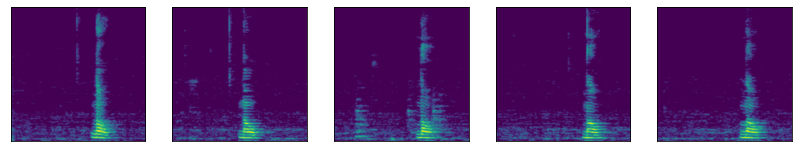

In [5]:
plt.figure(figsize=(14,14))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sounds[i].astype('float32'))
plt.show()

In [6]:
images = np.array(images)
images = images.reshape(images.shape[0], 30)
labels = np.array(labels)
sounds = np.array(sounds)
images, sounds, labels = shuffle(images, sounds, labels)

In [7]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(images, sounds, labels, train_size=0.8, random_state=1) 

In [8]:
print(x1_train.shape) # Results of Face_recognition_ML
print(x2_train.shape) # Sounds
print(y_train.shape)  # Labels

(16, 30)
(16, 256, 256)
(16,)


In [9]:
# Results of Face_recognition_ML
input_1 = tf.keras.layers.Input(shape=(30))

dense_1_1 = tf.keras.layers.Dense(16, activation="relu")(input_1)

dense_1_2 = tf.keras.layers.Dense(16, activation="relu")(dense_1_1)

dense_1_3 = tf.keras.layers.Dense(8, activation="relu")(dense_1_2)

dense_1_4 = tf.keras.layers.Dense(4, activation="relu")(dense_1_3)

# Sounds
input_2 = tf.keras.layers.Input(shape=(spec_width, spec_height, 1))

conv2d_2_1 = tf.keras.layers.Conv2D(128, kernel_size=5, activation="relu")(input_2)
pool_2_1 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_1)

conv2d_2_2 = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(pool_2_1)

conv2d_2_3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(conv2d_2_2)
pool_2_3 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_3)

conv2d_2_4 = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(pool_2_3)

conv2d_2_5 = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(conv2d_2_4)
pool_2_5 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_5)

flatten_2 = tf.keras.layers.Flatten()(pool_2_5)

# Concatenate
concat = tf.keras.layers.Concatenate()([dense_1_4, flatten_2])

dense_3_1 = tf.keras.layers.Dense(512, activation="relu")(concat)

dense_3_2 = tf.keras.layers.Dense(32, activation="relu")(dense_3_1)

output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_3_2)

model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

In [10]:
# # Results of Face_recognition_ML
# input_1 = tf.keras.layers.Input(shape=(30))

# dense_1_1 = tf.keras.layers.Dense(16, activation="relu")(input_1)

# dense_1_2 = tf.keras.layers.Dense(16, activation="relu")(dense_1_1)

# dense_1_3 = tf.keras.layers.Dense(8, activation="relu")(dense_1_2)

# dense_1_4 = tf.keras.layers.Dense(4, activation="relu")(dense_1_3)

# # Sounds
# input_2 = tf.keras.layers.Input(shape=(spec_width, spec_height, 1))

# conv2d_2_1 = tf.keras.layers.Conv2D(128, kernel_size=5, activation="relu")(input_2)
# pool_2_1 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_1)

# conv2d_2_2 = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(pool_2_1)

# conv2d_2_3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(conv2d_2_2)
# pool_2_3 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_3)

# conv2d_2_4 = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(pool_2_3)
# pool_2_4 = tf.keras.layers.MaxPooling2D(2)(conv2d_2_4)

# conv2d_2_5 = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(pool_2_4)

# flatten_2 = tf.keras.layers.Flatten()(conv2d_2_5)

# # Concatenate
# concat = tf.keras.layers.Concatenate()([dense_1_4, flatten_2])

# dense_3_1 = tf.keras.layers.Dense(4096, activation="relu")(concat)

# dense_3_2 = tf.keras.layers.Dense(512, activation="relu")(dense_3_1)

# dense_3_3 = tf.keras.layers.Dense(32, activation="relu")(dense_3_2)

# output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_3_3)

# model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 252, 252, 12  3328        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 126, 126, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

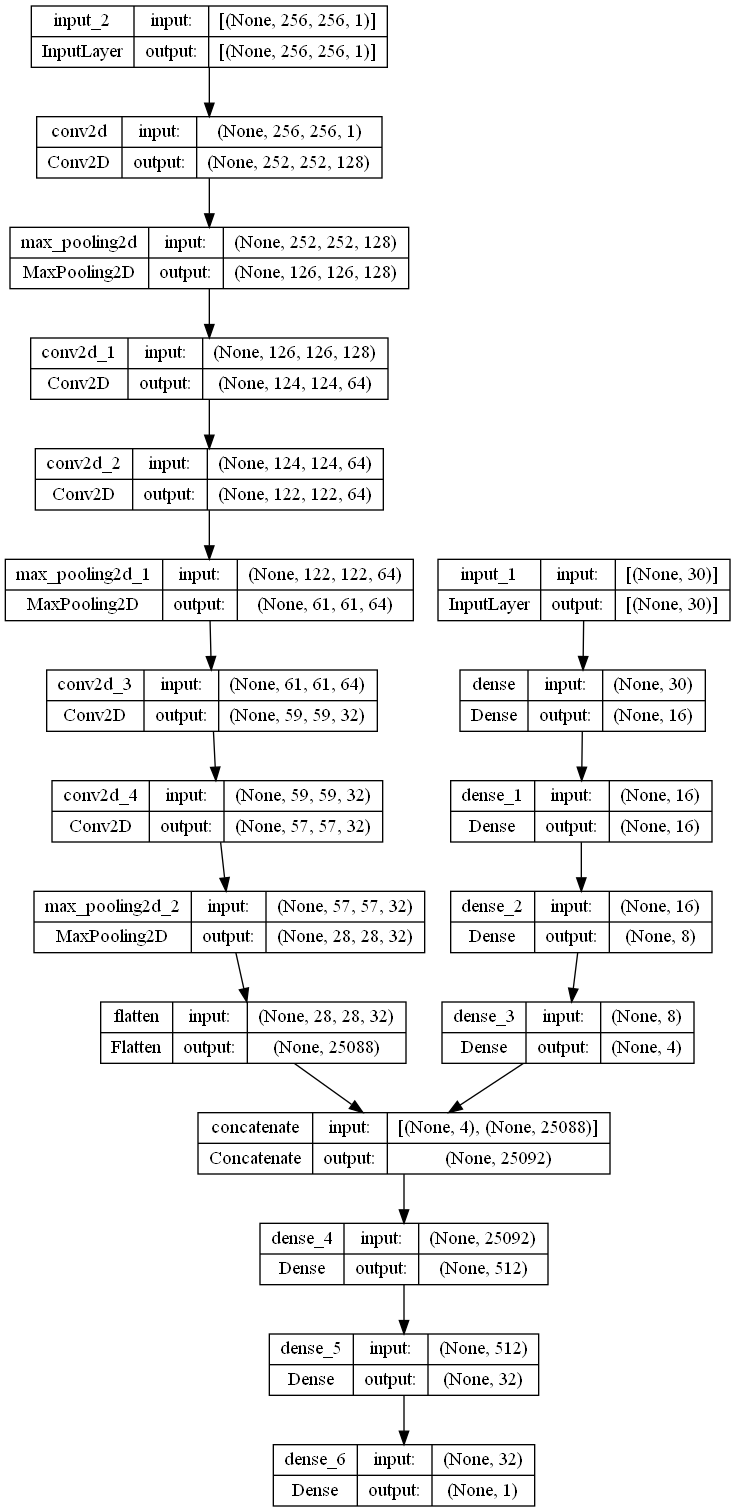

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="MeanSquaredError")

In [14]:
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
history = model.fit([x1_train, x2_train], y_train, validation_data=([x1_test, x2_test], y_test), batch_size=8, epochs=100, callbacks=[early_stop])

Epoch 1/100
2/2 [==============================] - 4s 1s/step - loss: 0.2445 - val_loss: 0.2535
Epoch 2/100
2/2 [==============================] - 0s 135ms/step - loss: 0.1529 - val_loss: 0.2746
Epoch 3/100
2/2 [==============================] - 0s 135ms/step - loss: 0.0292 - val_loss: 0.2907
Epoch 4/100
2/2 [==============================] - 0s 193ms/step - loss: 0.0028 - val_loss: 0.2524
Epoch 5/100
2/2 [==============================] - 0s 198ms/step - loss: 1.9572e-04 - val_loss: 0.2500
Epoch 6/100
2/2 [==============================] - 0s 140ms/step - loss: 0.0136 - val_loss: 0.2500
Epoch 7/100
2/2 [==============================] - 0s 164ms/step - loss: 1.7643e-06 - val_loss: 0.4942
Epoch 8/100
2/2 [==============================] - 0s 131ms/step - loss: 0.0475 - val_loss: 0.4660
Epoch 9/100
2/2 [==============================] - 0s 129ms/step - loss: 1.1411e-05 - val_loss: 0.3685
Epoch 10/100
2/2 [==============================] - 0s 136ms/step - loss: 7.2525e-14 - val_loss: 0.2

In [15]:
model.save('Magician.h5')

In [16]:
path_to_folder = 'C:/Users/Scrip0/Desktop/Internships/Magician AI/MagicianDatasetApp/Data/False/28_07_22_56_08_five/'
model = keras.models.load_model('Magician.h5')
fr_model = keras.models.load_model('Face_recognition.h5')

list_of_files = sorted(filter(lambda x: os.path.isfile(os.path.join(path_to_folder, x)), os.listdir(path_to_folder)))
imgs = []
for file in list_of_files:
    if (os.path.splitext(file)[1].split(".")[1] in sound_ext):
        sound = load_audio(path_to_folder + file)
    else: 
        imgs.append(load_img(path_to_folder + file))

imgs = fr_model.predict(np.array(imgs), verbose = 0)

In [17]:
imgs = imgs.reshape(1, num_imgs)
sound = sound.reshape(1, spec_width, spec_height)
print(sound.shape)
print(imgs.shape)

(1, 256, 256)
(1, 30)


In [18]:
model.predict([imgs, sound])[0][0]

1/1 [==============================] - 0s 423ms/step


0.0011019539